In [ ]:
pip install skfolio

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
import skfolio as sk
from skfolio import Population
from plotly.io import show

import matplotlib.pyplot as plt
from skfolio.preprocessing import prices_to_returns
yf.pdr_override()


# Portfolio Construction

In [ ]:
from datetime import datetime


# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'NVDA', 'ADBE', 'INTC', 'AMD', 'JPM', 'BLK', 'XOM', 'PFE']


end = '2024-01-01'
start = '2010-01-01'

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)


company_list = [AAPL, GOOG, NVDA, ADBE, INTC, AMD, JPM, BLK, XOM, PFE]
company_name = ["Apple", "Google","Nvidia", "Adobe", "Intel", "AMD", "JPMorgan Chase & Co", "Blackrock", "Exxon Mobil","Pfizer"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

colors = cm.viridis(np.linspace(0, 1, len(tech_list)))

df = pd.concat(company_list, axis=0)
df.head(10)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.470743,493729600,Apple
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.481929,601904800,Apple
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.378826,552160000,Apple
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.367032,477131200,Apple
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.409363,447610800,Apple
2010-01-11,7.600000,7.607143,7.444643,7.503929,6.352822,462229600,Apple
2010-01-12,7.471071,7.491786,7.372143,7.418571,6.280557,594459600,Apple
2010-01-13,7.423929,7.533214,7.289286,7.523214,6.369149,605892000,Apple
2010-01-14,7.503929,7.516429,7.465000,7.479643,6.332260,432894000,Apple


In [ ]:
NVDA.describe()
NVDA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3522 entries, 2010-01-04 to 2023-12-29
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3522 non-null   float64
 1   High          3522 non-null   float64
 2   Low           3522 non-null   float64
 3   Close         3522 non-null   float64
 4   Adj Close     3522 non-null   float64
 5   Volume        3522 non-null   int64  
 6   company_name  3522 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 220.1+ KB


### Data Analysis

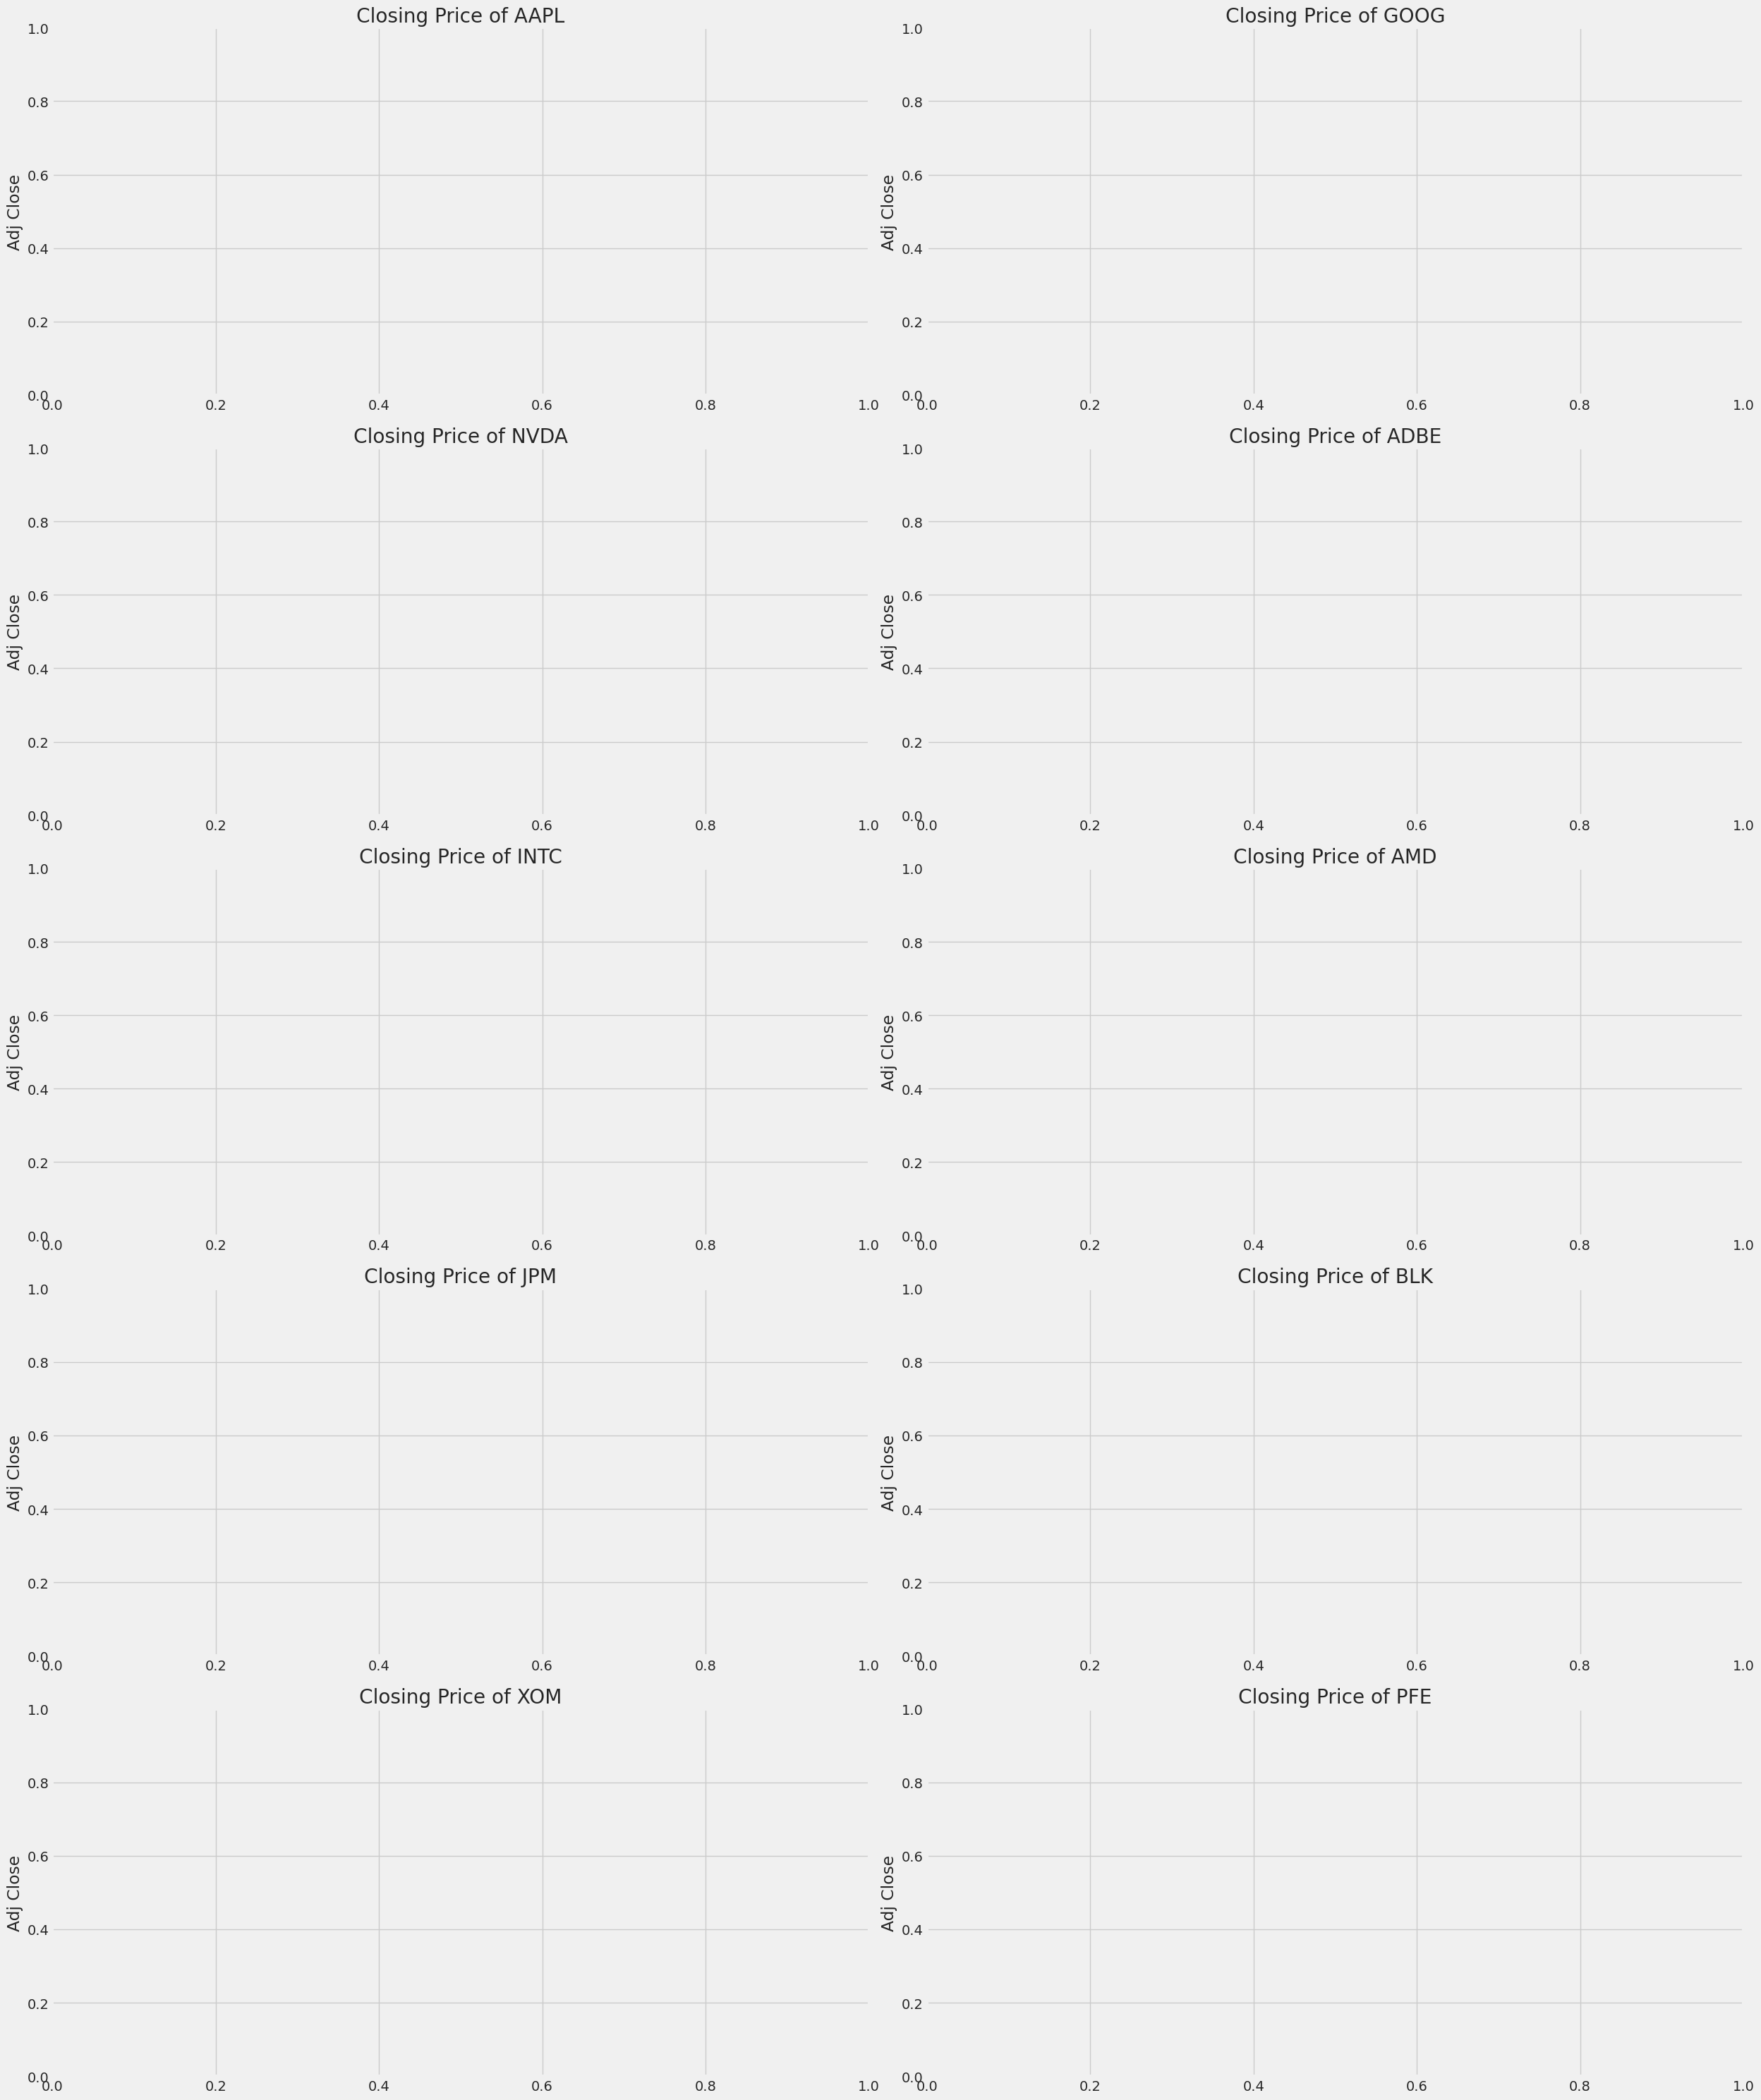

In [ ]:
plt.figure(figsize=(25, 30))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(5, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")

plt.tight_layout()

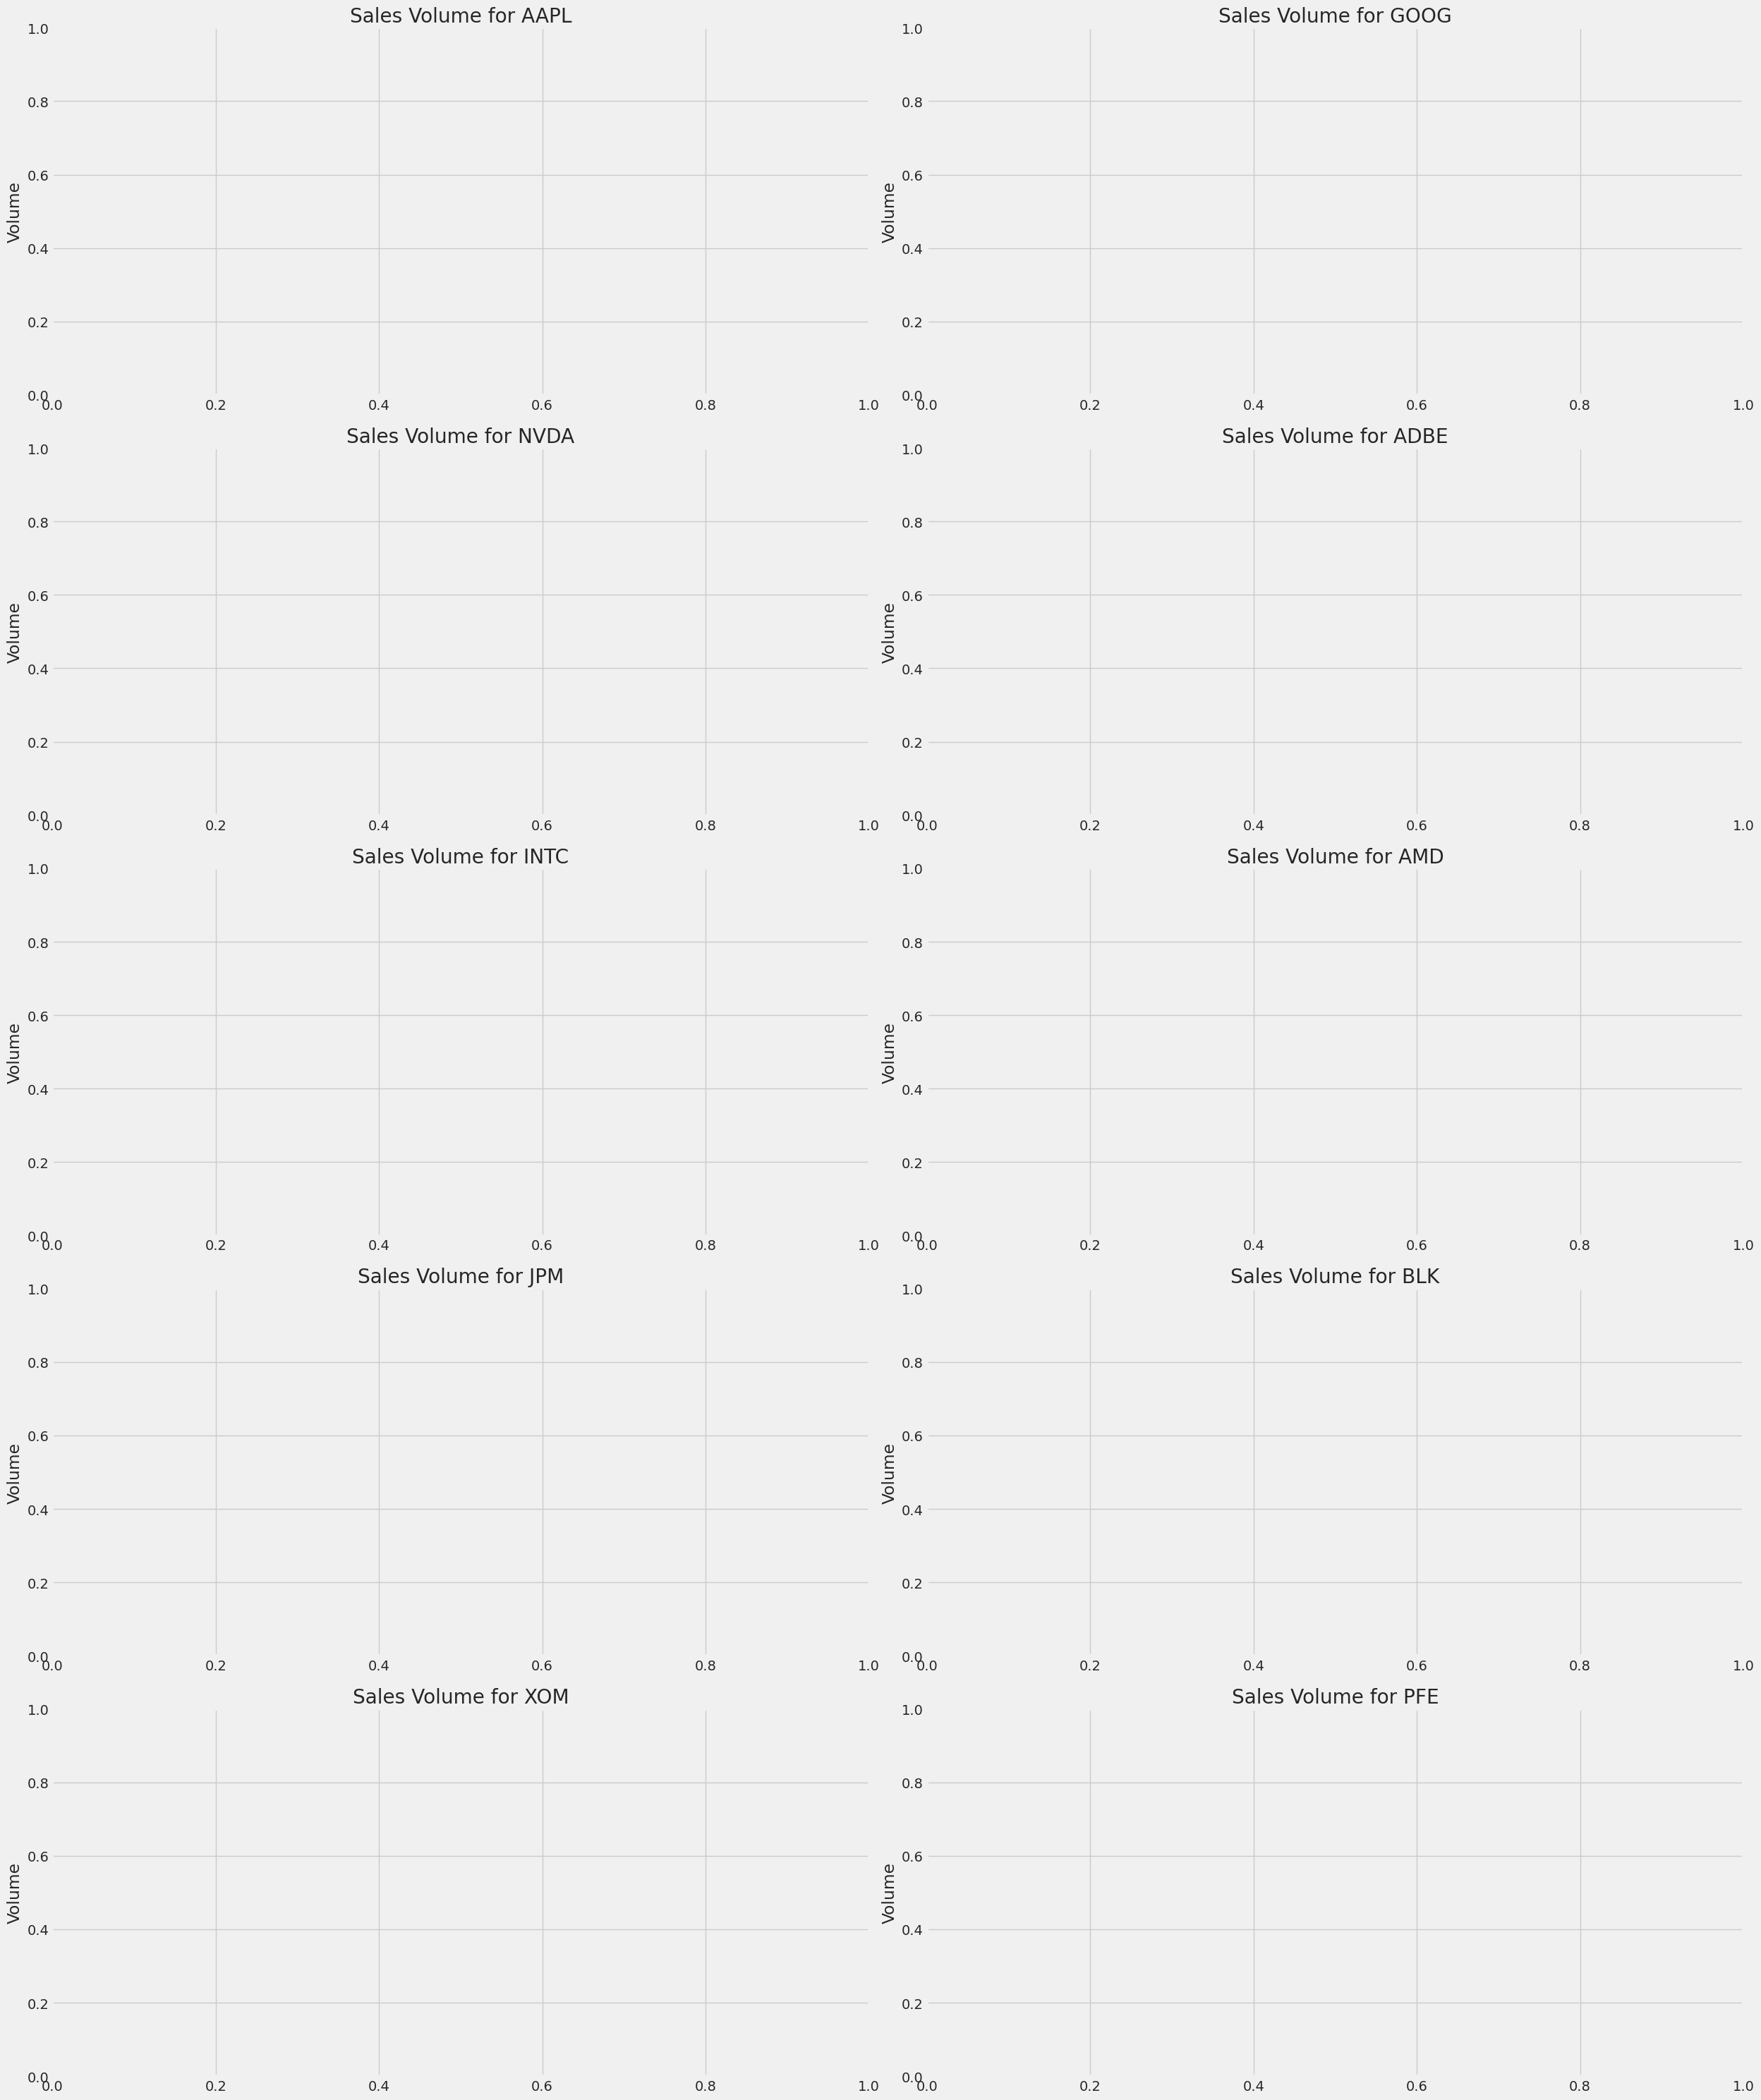

In [ ]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(25, 30))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(5, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {tech_list[i - 1]}")

plt.tight_layout()

In [ ]:
# Grab all the closing prices for the tech stock list into one DataFrame

closing_df = pdr.get_data_yahoo(tech_list, start=start, end=end)['Adj Close']

# Make a new tech returns DataFrame
tech_rets = closing_df.pct_change()
tech_rets.head()

[*********************100%%**********************]  10 of 10 completed


Ticker,AAPL,ADBE,AMD,BLK,GOOG,INTC,JPM,NVDA,PFE,XOM
Date,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.001729,0.016446,0.001031,0.004317,-0.004404,-0.000479,0.019370,0.014603,-0.014263,0.003904
2010-01-06,-0.015906,-0.002122,-0.014418,-0.020617,-0.025209,-0.003354,0.005494,0.006397,-0.003216,0.008643
2010-01-07,-0.001849,-0.019405,-0.010449,0.010994,-0.023280,-0.009615,0.019809,-0.019598,-0.003763,-0.003142
2010-01-08,0.006649,-0.005422,-0.004224,0.007039,0.013331,0.011165,-0.002456,0.002161,0.008095,-0.004012


Text(0.5, 1.0, 'Correlation of stock closing price')

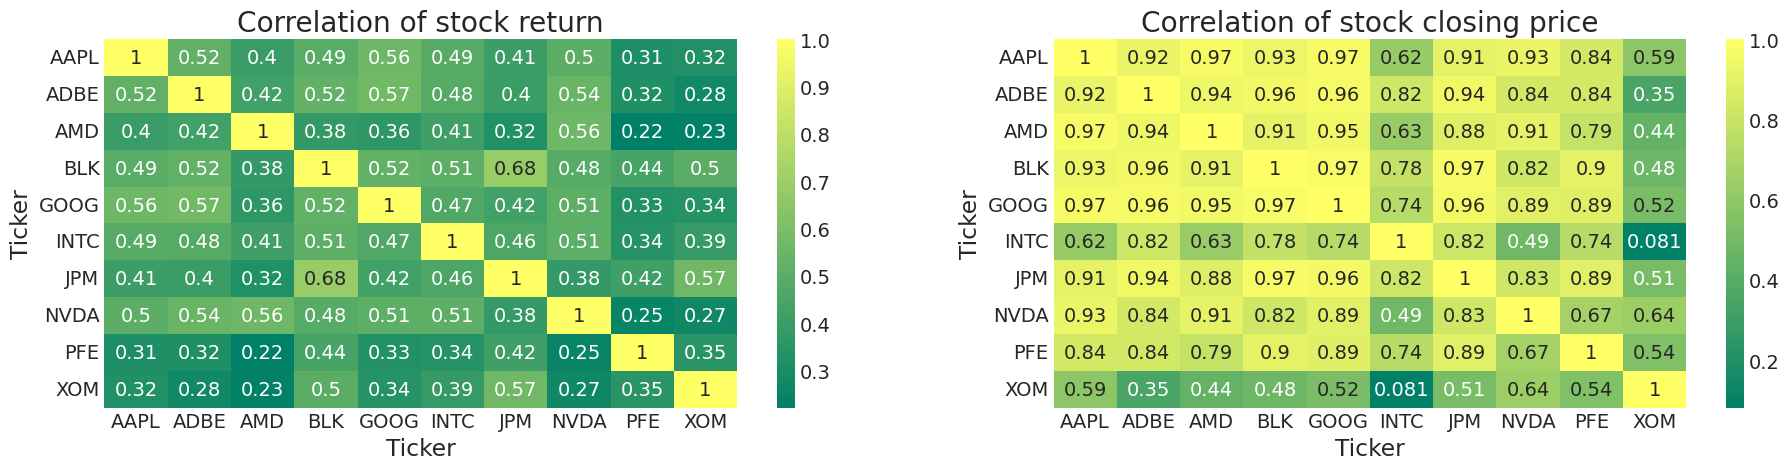

In [ ]:
fig = plt.figure(figsize=(20, 10))
fig.patch.set_facecolor('white')
plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')

### Risk
To quantify risk, one of the most basic ways using the information we've gathered on daily percentage returns is by comparing the expected return with the standard deviation of the daily returns.

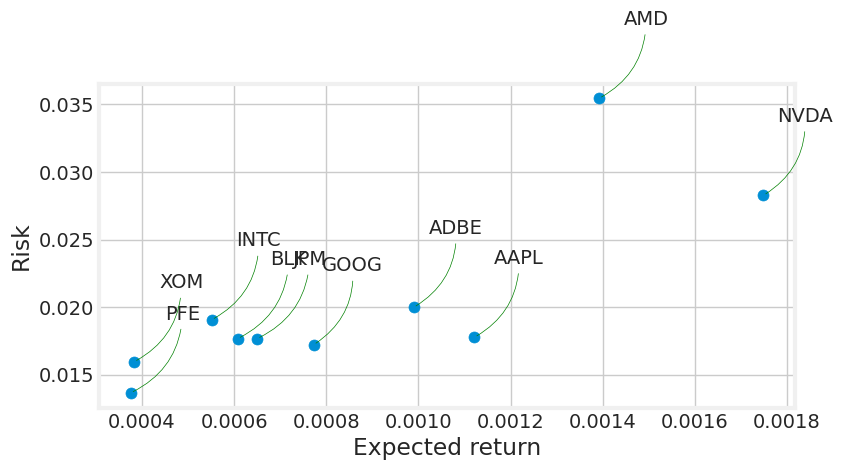

In [ ]:
rets = tech_rets.dropna()

area = np.pi * 20

fig = plt.figure(figsize=(8, 4))
fig.patch.set_facecolor('white')
ax = plt.gca()
ax.set_facecolor('white')
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')
fig.patch.set_facecolor('white')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom',
                 arrowprops=dict(arrowstyle='-', color='green', connectionstyle='arc3,rad=-0.3'))


## Implementation

In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.470743,493729600,Apple
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.481929,601904800,Apple
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.378826,552160000,Apple
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.367032,477131200,Apple
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.409363,447610800,Apple
...,...,...,...,...,...,...,...
2023-12-22,28.440001,28.790001,28.180000,28.400000,27.978962,35087200,Pfizer
2023-12-26,28.430000,28.530001,28.250000,28.410000,27.988813,30119100,Pfizer
2023-12-27,28.469999,28.730000,28.309999,28.610001,28.185850,35000700,Pfizer


In [ ]:
#Preprocessing data
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)

df['Target'] = df.groupby('company_name')['Close'].shift(-1)
df.dropna(inplace=True) #drop all cells, empty or without any target value

df

,Date,Open,High,Low,Close,Adj Close,Volume,company_name,Target
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.470743,493729600,Apple,7.656429
21132,2010-01-04,41.790001,42.990002,41.669998,42.849998,29.497776,35460500,JPMorgan Chase & Co,43.680000
17610,2010-01-04,9.790000,9.900000,9.680000,9.700000,9.700000,18748700,AMD,9.710000
28176,2010-01-04,68.720001,69.260002,68.190002,69.150002,40.237797,27809100,Exxon Mobil,69.419998
14088,2010-01-04,20.790001,21.030001,20.730000,20.879999,13.660447,47800900,Intel,20.870001
...,...,...,...,...,...,...,...,...,...
10564,2023-12-28,496.429993,498.839996,494.119995,495.220001,495.196777,24658700,Nvidia,495.220001
35218,2023-12-28,28.610001,29.030001,28.580000,28.790001,28.363180,30472900,Pfizer,28.790001
17608,2023-12-28,50.810001,50.869999,50.160000,50.389999,50.242729,27705200,Intel,50.250000
3520,2023-12-28,194.139999,194.660004,193.169998,193.580002,193.333298,34049900,Apple,192.529999


Company: Apple, Number of data points: 3521
Company: Google, Number of data points: 3521
Company: Nvidia, Number of data points: 3521
Company: Adobe, Number of data points: 3521
Company: Intel, Number of data points: 3521
Company: AMD, Number of data points: 3521
Company: JPMorgan Chase & Co, Number of data points: 3521
Company: Blackrock, Number of data points: 3521
Company: Exxon Mobil, Number of data points: 3521
Company: Pfizer, Number of data points: 3521


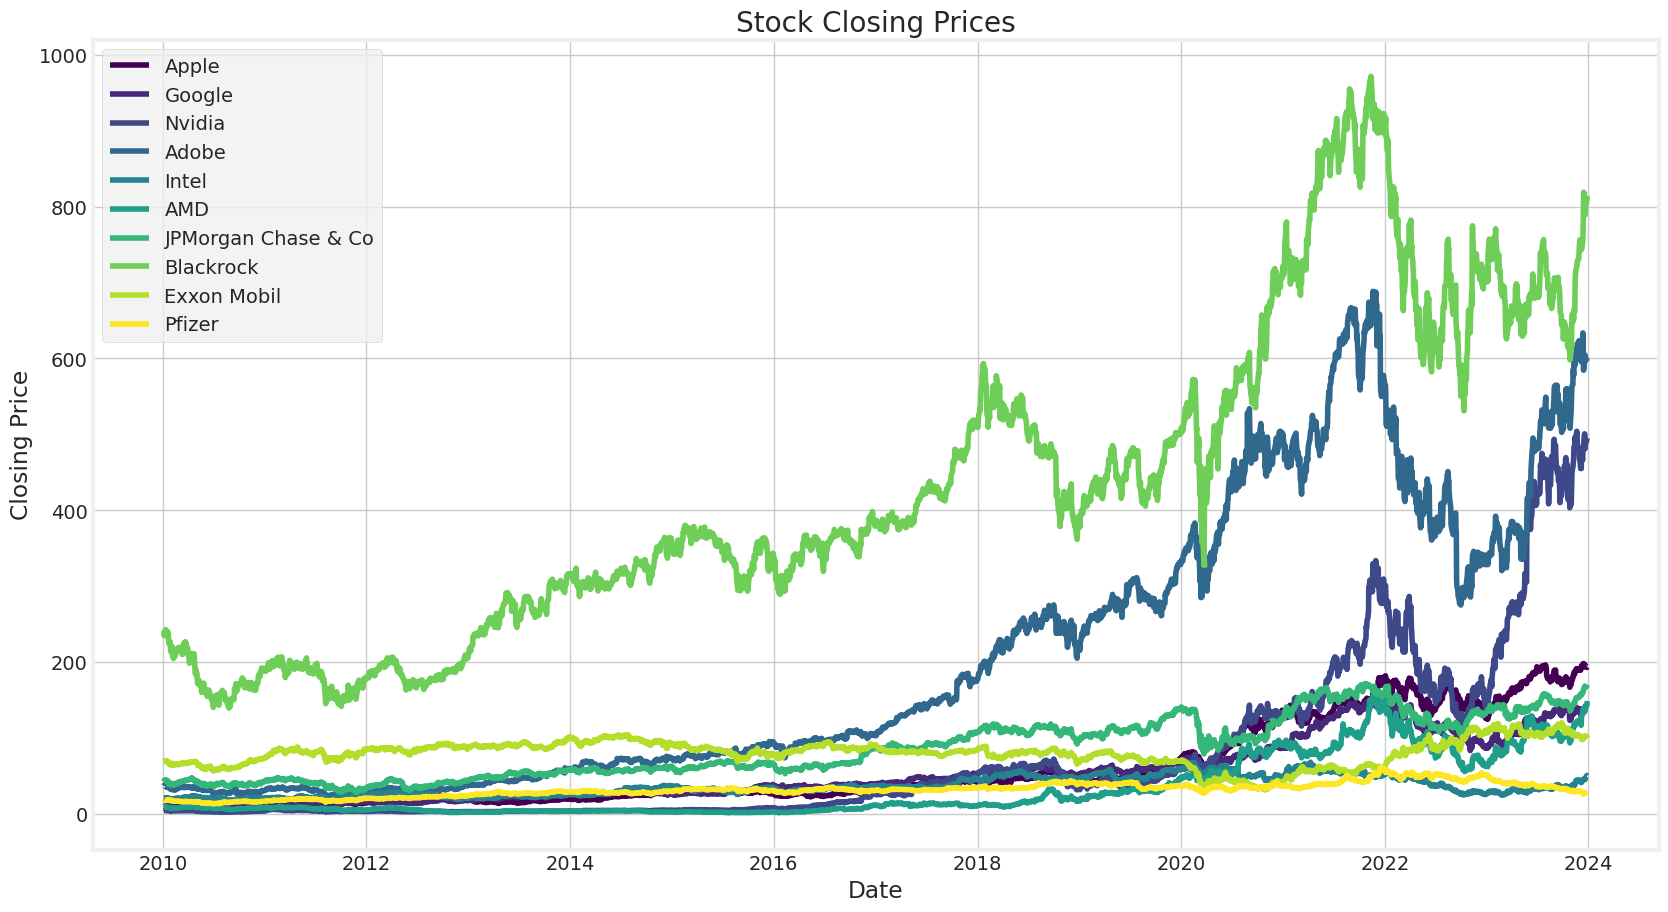

In [ ]:
# Visualize the closing prices
fig = plt.figure(figsize=(18, 10))
fig.patch.set_facecolor('white')
ax = plt.gca()
ax.set_facecolor('white')
for company, color in zip (company_name, colors):
    company_data = df[df['company_name'] == company]
    print(f"Company: {company}, Number of data points: {len(company_data)}")
    plt.plot(company_data['Date'], company_data['Close'], label=company, color=color)
plt.title('Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# Implementation

[*********************100%%**********************]  1 of 1 completed


Epoch 1/10
36/36 [==============================] - 13s 154ms/step - loss: 0.0010
Epoch 2/10
36/36 [==============================] - 8s 224ms/step - loss: 3.4586e-05
Epoch 3/10
36/36 [==============================] - 6s 155ms/step - loss: 2.8058e-05
Epoch 4/10
36/36 [==============================] - 7s 190ms/step - loss: 2.6441e-05
Epoch 5/10
36/36 [==============================] - 6s 156ms/step - loss: 2.5592e-05
Epoch 6/10
36/36 [==============================] - 7s 191ms/step - loss: 2.4602e-05
Epoch 7/10
36/36 [==============================] - 6s 157ms/step - loss: 2.4562e-05
Epoch 8/10
36/36 [==============================] - 7s 191ms/step - loss: 2.3861e-05
Epoch 9/10
36/36 [==============================] - 6s 155ms/step - loss: 2.4018e-05
Epoch 10/10
37/37 [==============================] - 2s 36ms/step
RMSE for AAPL: 6.372513819375342


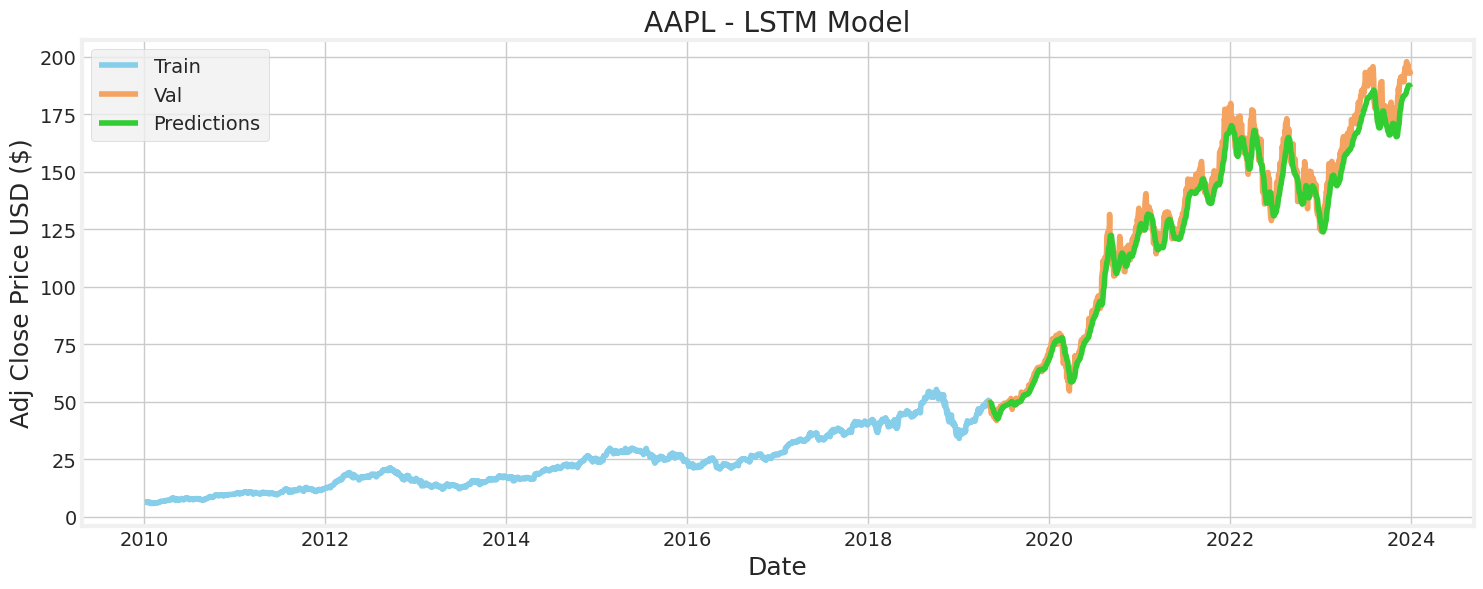

[*********************100%%**********************]  1 of 1 completed


Epoch 1/10
36/36 [==============================] - 11s 186ms/step - loss: 0.0029
Epoch 2/10
36/36 [==============================] - 6s 161ms/step - loss: 8.2676e-05
Epoch 3/10
36/36 [==============================] - 8s 208ms/step - loss: 5.5971e-05
Epoch 4/10
36/36 [==============================] - 6s 175ms/step - loss: 5.8413e-05
Epoch 5/10
36/36 [==============================] - 6s 173ms/step - loss: 5.7182e-05
Epoch 6/10
36/36 [==============================] - 6s 172ms/step - loss: 6.3635e-05
Epoch 7/10
36/36 [==============================] - 6s 175ms/step - loss: 5.8419e-05
Epoch 8/10
36/36 [==============================] - 6s 169ms/step - loss: 5.7907e-05
Epoch 9/10
36/36 [==============================] - 6s 177ms/step - loss: 5.5121e-05
Epoch 10/10
37/37 [==============================] - 2s 37ms/step
RMSE for GOOG: 4.49360667343048


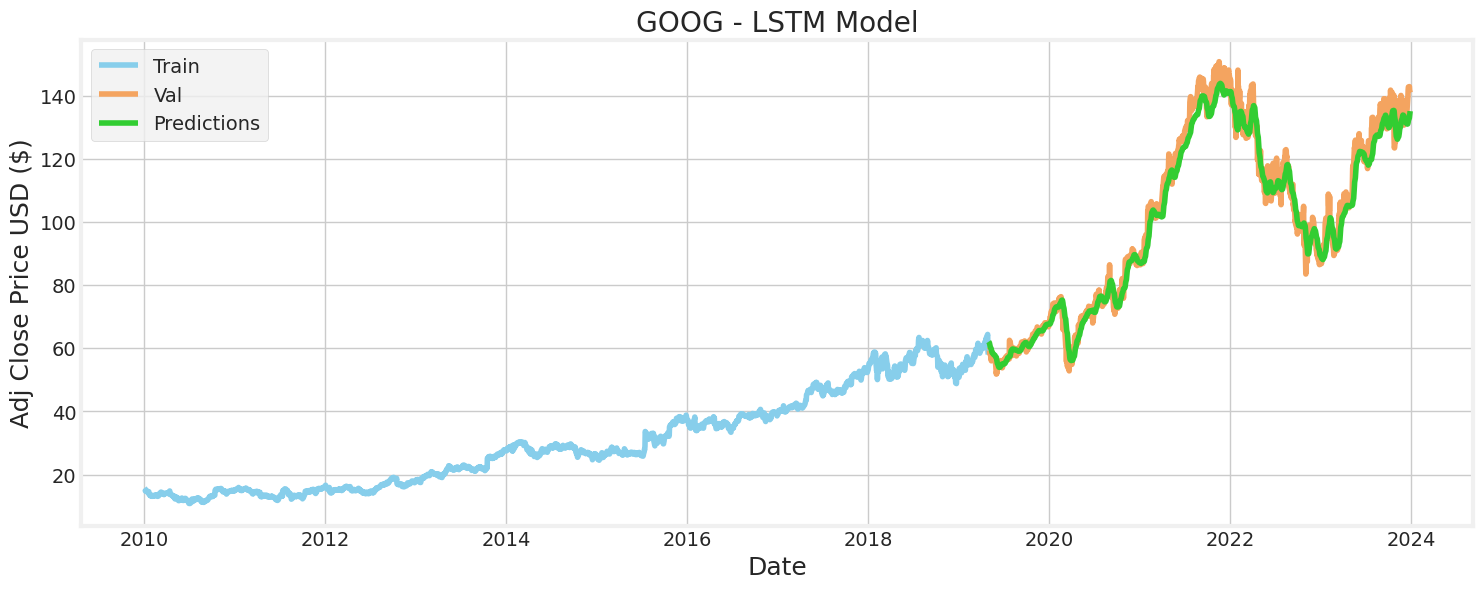

[*********************100%%**********************]  1 of 1 completed


Epoch 1/10
36/36 [==============================] - 11s 186ms/step - loss: 2.3918e-04
Epoch 2/10
36/36 [==============================] - 7s 198ms/step - loss: 1.2543e-05
Epoch 3/10
36/36 [==============================] - 6s 157ms/step - loss: 1.0478e-05
Epoch 4/10
36/36 [==============================] - 7s 196ms/step - loss: 1.0351e-05
Epoch 5/10
36/36 [==============================] - 6s 159ms/step - loss: 9.1696e-06
Epoch 6/10
36/36 [==============================] - 7s 194ms/step - loss: 8.2159e-06
Epoch 7/10
36/36 [==============================] - 6s 160ms/step - loss: 8.7583e-06
Epoch 8/10
36/36 [==============================] - 7s 195ms/step - loss: 9.2221e-06
Epoch 9/10
36/36 [==============================] - 6s 159ms/step - loss: 8.1651e-06
Epoch 10/10
37/37 [==============================] - 2s 38ms/step
RMSE for NVDA: 18.771178568453387


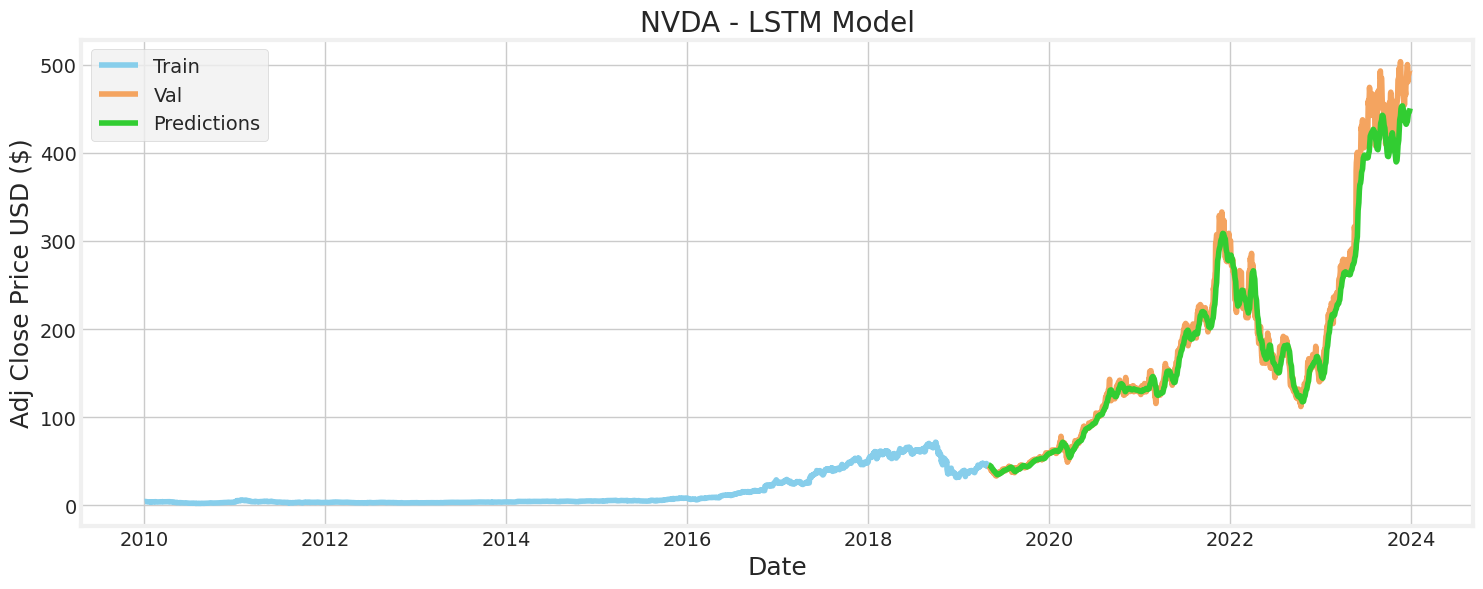

[*********************100%%**********************]  1 of 1 completed


Epoch 1/10
36/36 [==============================] - 10s 161ms/step - loss: 0.0024
Epoch 2/10
36/36 [==============================] - 7s 196ms/step - loss: 6.5223e-05
Epoch 3/10
36/36 [==============================] - 6s 160ms/step - loss: 3.3977e-05
Epoch 4/10
36/36 [==============================] - 7s 195ms/step - loss: 3.3788e-05
Epoch 5/10
36/36 [==============================] - 6s 159ms/step - loss: 3.3556e-05
Epoch 6/10
36/36 [==============================] - 7s 196ms/step - loss: 3.5131e-05
Epoch 7/10
36/36 [==============================] - 6s 157ms/step - loss: 3.2764e-05
Epoch 8/10
36/36 [==============================] - 7s 193ms/step - loss: 3.3316e-05
Epoch 9/10
36/36 [==============================] - 6s 162ms/step - loss: 3.2573e-05
Epoch 10/10
37/37 [==============================] - 3s 68ms/step
RMSE for ADBE: 23.08293894225595


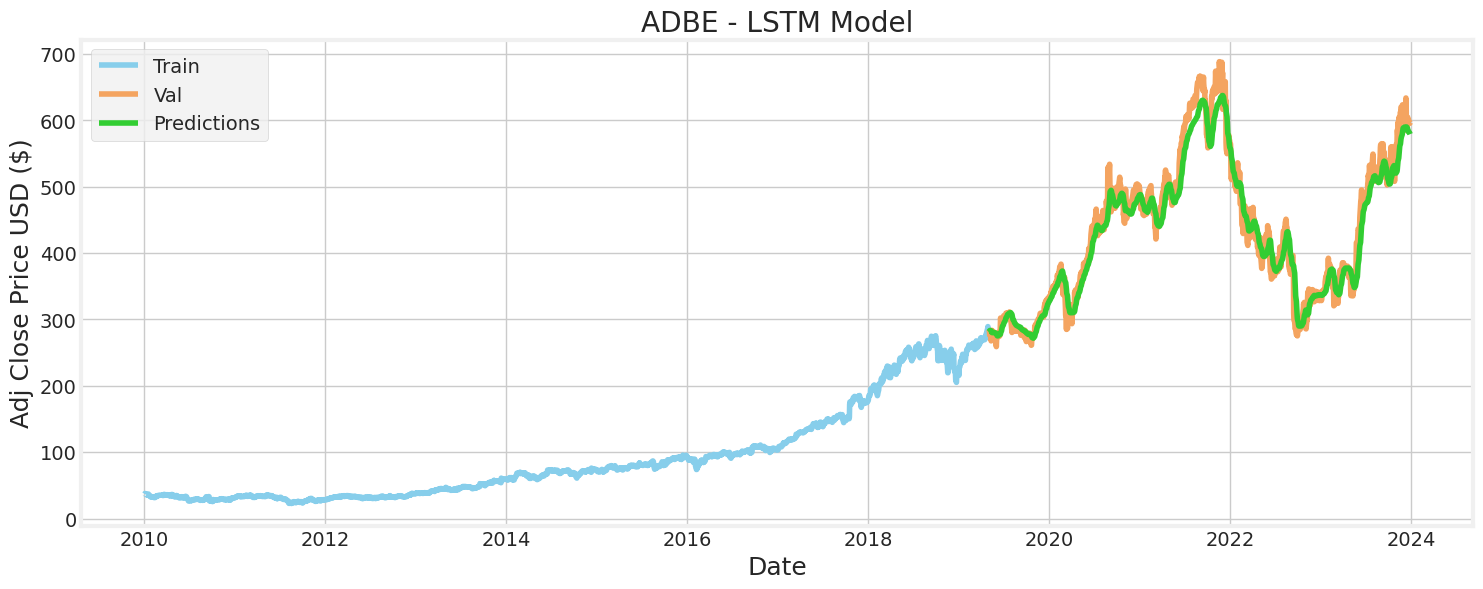

[*********************100%%**********************]  1 of 1 completed


Epoch 1/10
36/36 [==============================] - 11s 197ms/step - loss: 0.0095
Epoch 2/10
36/36 [==============================] - 6s 159ms/step - loss: 4.2078e-04
Epoch 3/10
36/36 [==============================] - 7s 197ms/step - loss: 3.0370e-04
Epoch 4/10
36/36 [==============================] - 6s 161ms/step - loss: 2.9489e-04
Epoch 5/10
36/36 [==============================] - 7s 199ms/step - loss: 2.8466e-04
Epoch 6/10
36/36 [==============================] - 6s 164ms/step - loss: 2.9210e-04
Epoch 7/10
36/36 [==============================] - 7s 196ms/step - loss: 2.7468e-04
Epoch 8/10
36/36 [==============================] - 6s 163ms/step - loss: 2.7498e-04
Epoch 9/10
36/36 [==============================] - 7s 196ms/step - loss: 2.6313e-04
Epoch 10/10
37/37 [==============================] - 3s 41ms/step
RMSE for INTC: 1.990427226378961


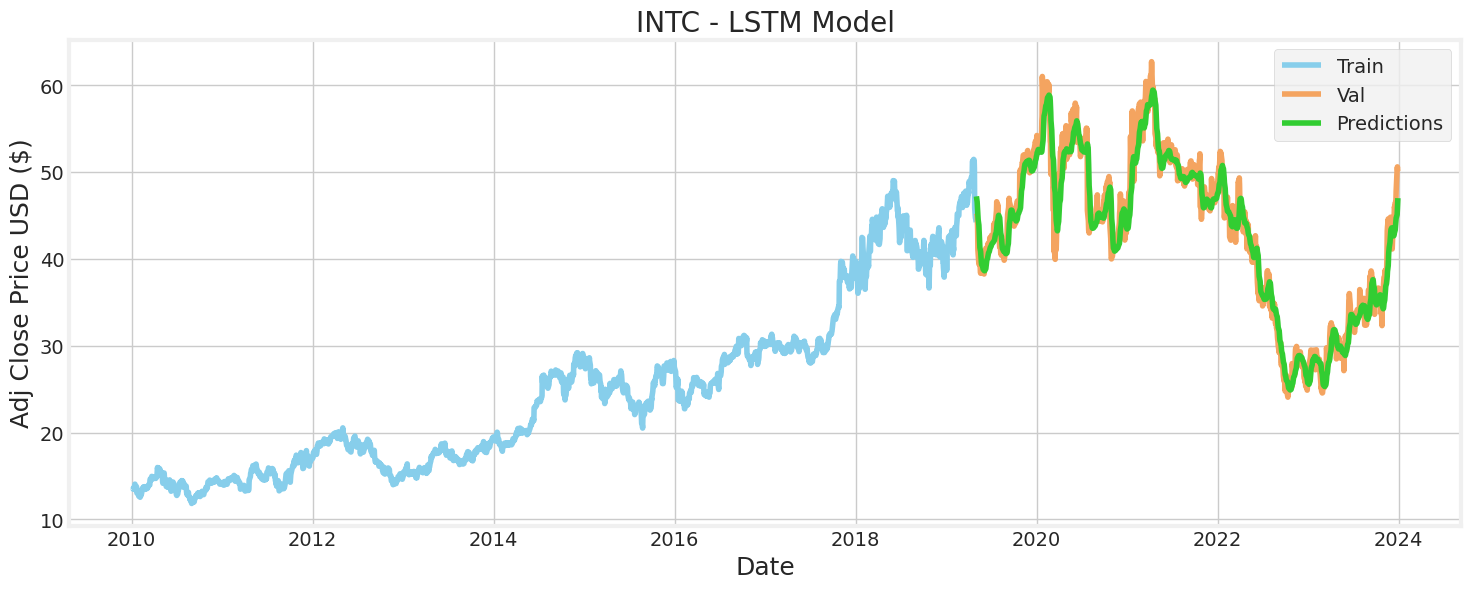

[*********************100%%**********************]  1 of 1 completed


Epoch 1/10
36/36 [==============================] - 11s 189ms/step - loss: 3.6628e-04
Epoch 2/10
36/36 [==============================] - 6s 178ms/step - loss: 3.3889e-05
Epoch 3/10
36/36 [==============================] - 7s 184ms/step - loss: 2.7549e-05
Epoch 4/10
36/36 [==============================] - 7s 193ms/step - loss: 2.6086e-05
Epoch 5/10
36/36 [==============================] - 6s 173ms/step - loss: 2.4819e-05
Epoch 6/10
36/36 [==============================] - 8s 232ms/step - loss: 2.2898e-05
Epoch 7/10
36/36 [==============================] - 6s 168ms/step - loss: 2.3335e-05
Epoch 8/10
36/36 [==============================] - 7s 201ms/step - loss: 2.2550e-05
Epoch 9/10
36/36 [==============================] - 6s 169ms/step - loss: 2.1009e-05
Epoch 10/10
37/37 [==============================] - 2s 40ms/step
RMSE for AMD: 5.657339611474631


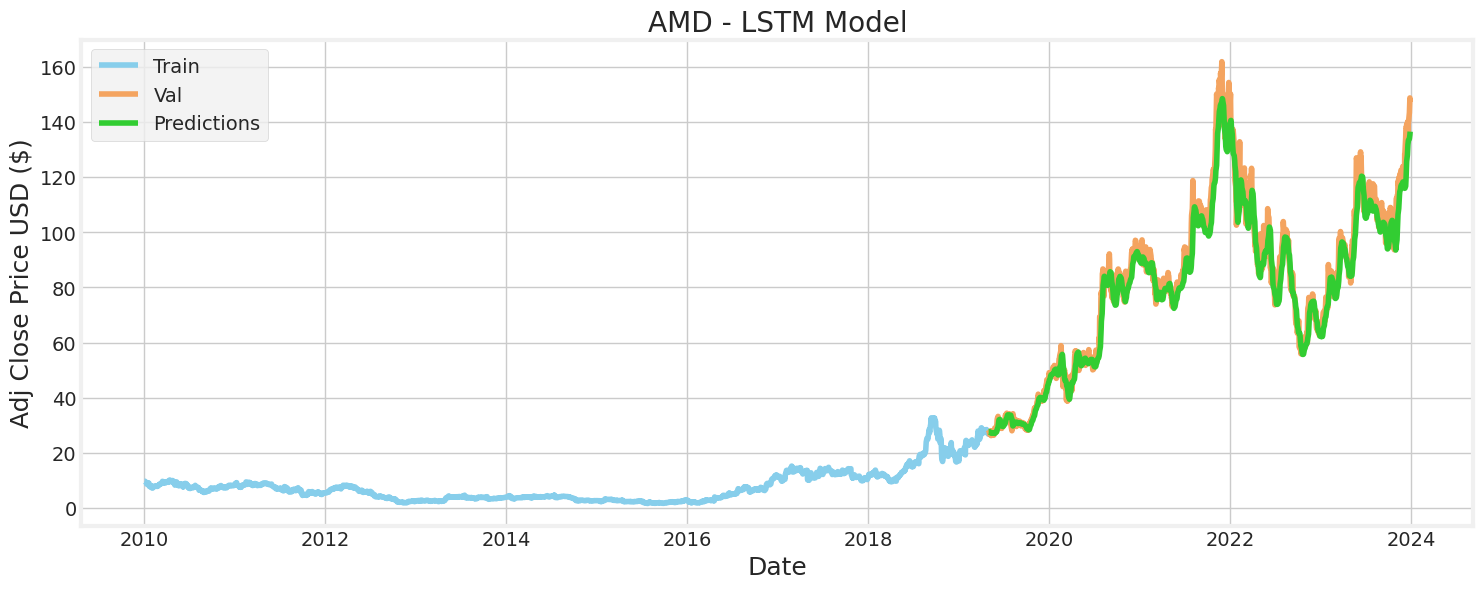

[*********************100%%**********************]  1 of 1 completed


Epoch 1/10
36/36 [==============================] - 11s 201ms/step - loss: 0.0044
Epoch 2/10
36/36 [==============================] - 6s 165ms/step - loss: 1.4101e-04
Epoch 3/10
36/36 [==============================] - 7s 201ms/step - loss: 1.2788e-04
Epoch 4/10
36/36 [==============================] - 6s 165ms/step - loss: 1.2599e-04
Epoch 5/10
36/36 [==============================] - 7s 199ms/step - loss: 1.2193e-04
Epoch 6/10
36/36 [==============================] - 6s 167ms/step - loss: 1.1908e-04
Epoch 7/10
36/36 [==============================] - 7s 201ms/step - loss: 1.1571e-04
Epoch 8/10
36/36 [==============================] - 6s 174ms/step - loss: 1.1335e-04
Epoch 9/10
36/36 [==============================] - 7s 189ms/step - loss: 1.1173e-04
Epoch 10/10
37/37 [==============================] - 2s 39ms/step
RMSE for JPM: 5.134916703272815


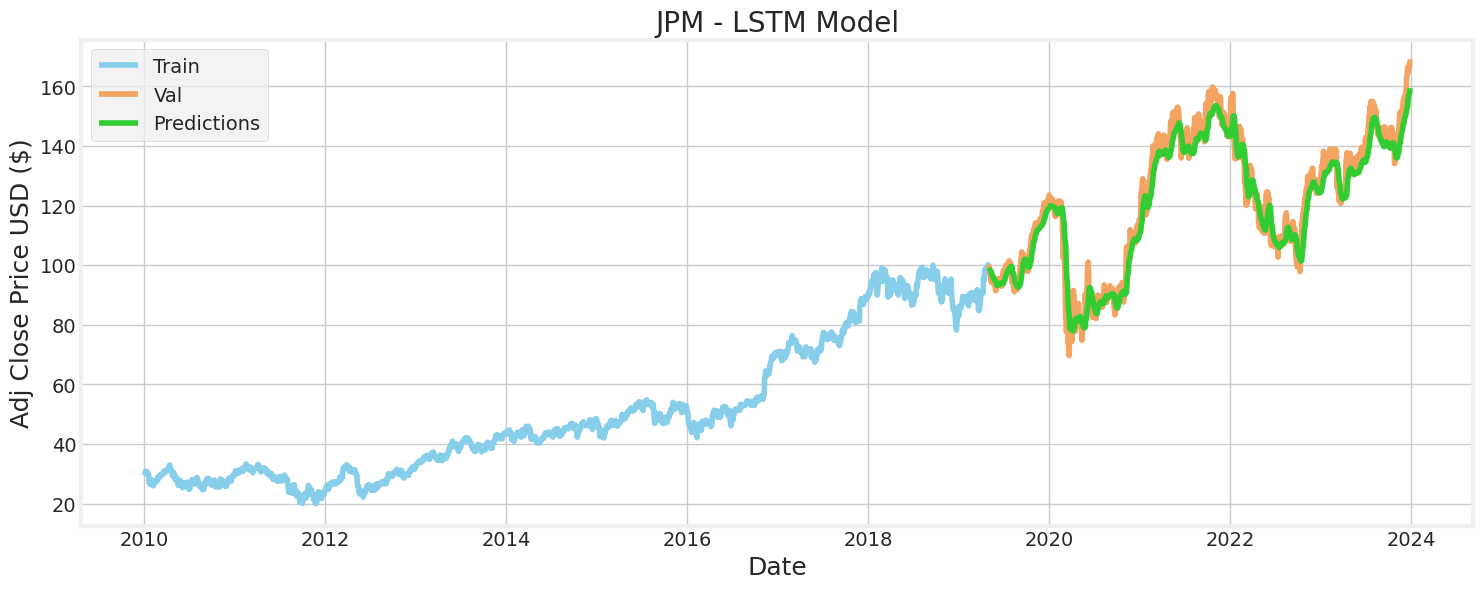

[*********************100%%**********************]  1 of 1 completed


Epoch 1/10
36/36 [==============================] - 11s 187ms/step - loss: 0.0035
Epoch 2/10
36/36 [==============================] - 7s 183ms/step - loss: 1.5920e-04
Epoch 3/10
36/36 [==============================] - 7s 181ms/step - loss: 1.1582e-04
Epoch 4/10
36/36 [==============================] - 7s 191ms/step - loss: 1.1523e-04
Epoch 5/10
36/36 [==============================] - 8s 207ms/step - loss: 1.1588e-04
Epoch 6/10
36/36 [==============================] - 7s 200ms/step - loss: 1.1065e-04
Epoch 7/10
36/36 [==============================] - 6s 167ms/step - loss: 1.0665e-04
Epoch 8/10
36/36 [==============================] - 7s 202ms/step - loss: 1.0458e-04
Epoch 9/10
36/36 [==============================] - 6s 164ms/step - loss: 1.0473e-04
Epoch 10/10
37/37 [==============================] - 2s 40ms/step
RMSE for BLK: 24.64846692524134


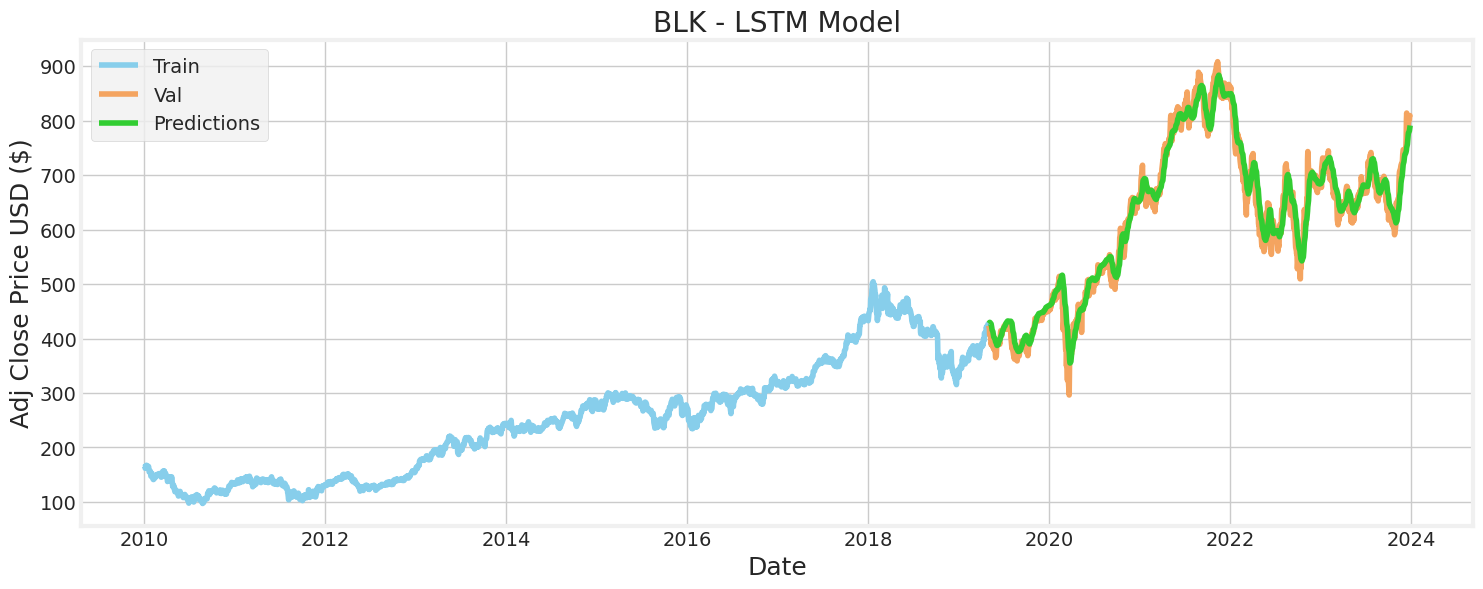

[*********************100%%**********************]  1 of 1 completed


Epoch 1/10
36/36 [==============================] - 12s 169ms/step - loss: 0.0086
Epoch 2/10
36/36 [==============================] - 7s 204ms/step - loss: 6.7469e-04
Epoch 3/10
36/36 [==============================] - 6s 171ms/step - loss: 2.6420e-04
Epoch 4/10
36/36 [==============================] - 7s 206ms/step - loss: 2.1959e-04
Epoch 5/10
36/36 [==============================] - 6s 167ms/step - loss: 2.1952e-04
Epoch 6/10
36/36 [==============================] - 7s 202ms/step - loss: 2.1433e-04
Epoch 7/10
36/36 [==============================] - 6s 170ms/step - loss: 2.1612e-04
Epoch 8/10
36/36 [==============================] - 7s 204ms/step - loss: 2.1012e-04
Epoch 9/10
36/36 [==============================] - 6s 170ms/step - loss: 2.0391e-04
Epoch 10/10
37/37 [==============================] - 2s 42ms/step
RMSE for XOM: 2.9367053362916167


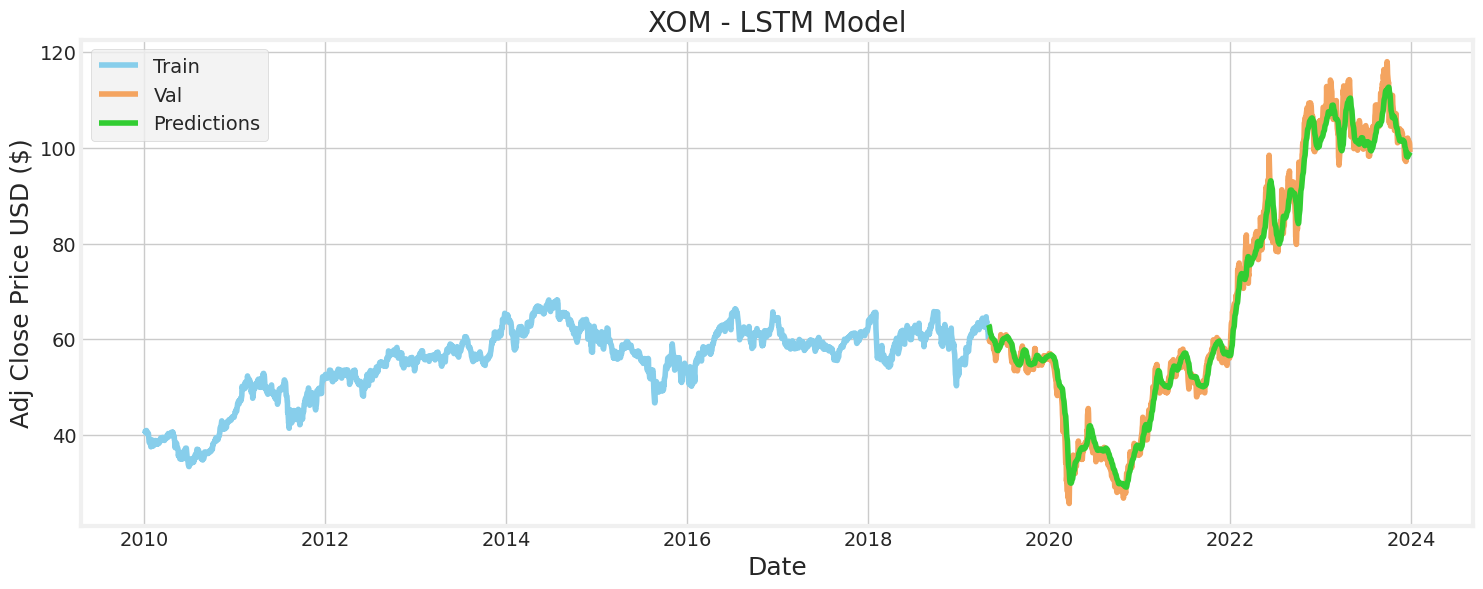

[*********************100%%**********************]  1 of 1 completed


Epoch 1/10
36/36 [==============================] - 11s 178ms/step - loss: 0.0068
Epoch 2/10
36/36 [==============================] - 7s 202ms/step - loss: 2.2133e-04
Epoch 3/10
36/36 [==============================] - 7s 203ms/step - loss: 1.1964e-04
Epoch 4/10
36/36 [==============================] - 7s 203ms/step - loss: 1.1087e-04
Epoch 5/10
36/36 [==============================] - 6s 167ms/step - loss: 1.1187e-04
Epoch 6/10
36/36 [==============================] - 7s 202ms/step - loss: 1.0978e-04
Epoch 7/10
36/36 [==============================] - 6s 167ms/step - loss: 1.0635e-04
Epoch 8/10
36/36 [==============================] - 7s 203ms/step - loss: 1.0577e-04
Epoch 9/10
36/36 [==============================] - 6s 172ms/step - loss: 1.0875e-04
Epoch 10/10
37/37 [==============================] - 2s 41ms/step
RMSE for PFE: 1.4568820190956853


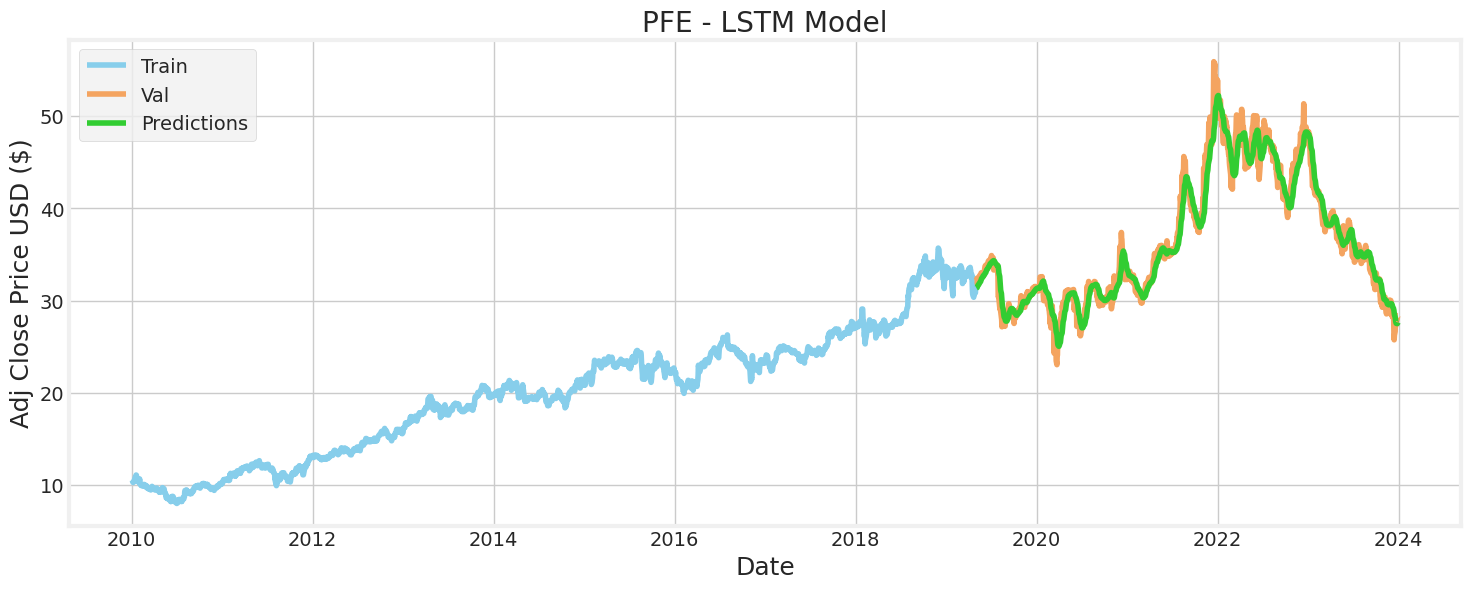

In [ ]:

def train_lstm_model(stock_data):
    # Get the number of rows to train the model on
    training_data_len = int(np.ceil(len(stock_data) * (2/3)))

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(stock_data)

    # Split the data into training and testing sets
    train_data = scaled_data[0:int(training_data_len), :]
    x_train, y_train = [], []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(x_train, y_train, batch_size=64, epochs=10)

    # Test data
    test_data = scaled_data[training_data_len - 60:, :]
    x_test, y_test = [], stock_data[training_data_len:, :]

    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Get predictions
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    return model, predictions, y_test

predicted_returns_df = pd.DataFrame()
actual_returns_df = pd.DataFrame()

for i, stock_symbol in enumerate(tech_list):

    stock_data = yf.download(stock_symbol, start, end)
    stock_data.reset_index(inplace=True)
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data.set_index('Date', inplace=True)

    stock_close_values = stock_data['Adj Close'].values.reshape(-1, 1)
    model, predictions, y_test = train_lstm_model(stock_close_values)

    predicted_returns_df[stock_symbol] = predictions.flatten()
    predicted_returns_df.index = stock_data.index[-len(predictions):]

    actual_returns_df[stock_symbol] = y_test.flatten()
    actual_returns_df.index = stock_data.index[-len(predictions):]

    # RMSE
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    print(f"RMSE for {stock_symbol}: {rmse}")
    fig = plt.figure(figsize=(16, 6))
    fig.patch.set_facecolor('white')
    ax = plt.gca()
    ax.set_facecolor('white')
    plt.title(f'{stock_symbol} - LSTM Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Adj Close Price USD ($)', fontsize=18)
    # plt.plot(stock_data.index, stock_data['Adj Close'], label='Training Data')
    # plt.plot(stock_data.index[-len(predictions):], predictions, label='LSTM Predictions')

    train_end_idx = int(len(stock_data) * (2/3))
    plt.plot(stock_data.index[:train_end_idx], stock_data['Adj Close'][:train_end_idx], label='Train', color='skyblue')
    plt.plot(stock_data.index[train_end_idx:], stock_data['Adj Close'][train_end_idx:], label='Val', color='sandybrown')
    plt.plot(stock_data.index[train_end_idx:], predictions, label='Predictions', color='limegreen')
    plt.legend()
    plt.show()





In [ ]:
print(model.summary)

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x7dd4c18ae4a0>>


In [ ]:
predicted_returns_df

,AAPL,GOOG,NVDA,ADBE,INTC,AMD,JPM,BLK,XOM,PFE
Date,,,,,,,,,,
2019-05-03,49.213993,62.080673,45.842453,281.035706,47.213493,27.661541,97.755074,427.311707,63.022621,31.360083
2019-05-06,49.371830,61.734489,45.665871,282.059875,46.582981,27.680145,98.075829,428.708221,62.687996,31.405622
2019-05-07,49.518990,61.387959,45.488026,282.928589,46.055759,27.664650,98.311455,429.647949,62.323071,31.487833
2019-05-08,49.585072,61.023285,45.218975,283.326263,45.590157,27.559326,98.390518,429.669891,61.941166,31.562487
2019-05-09,49.581760,60.647095,44.912663,283.373138,45.125290,27.440182,98.335228,429.117462,61.571827,31.632717
...,...,...,...,...,...,...,...,...,...,...
2023-12-22,187.615204,132.172211,445.585938,582.809326,44.703880,133.420303,156.567978,777.405762,98.568810,27.530342
2023-12-26,187.561050,132.903397,447.059448,581.769897,45.112011,133.899384,157.316711,781.130920,98.754402,27.502476
2023-12-27,187.363647,133.697632,448.432922,580.849487,45.690338,134.508698,158.012848,784.549194,98.946625,27.512045


In [ ]:
actual_returns_df

,AAPL,GOOG,NVDA,ADBE,INTC,AMD,JPM,BLK,XOM,PFE
Date,,,,,,,,,,
2019-05-03,50.962872,59.270000,45.441772,285.579987,45.286972,28.219999,100.153687,423.732971,60.094208,32.233242
2019-05-06,50.175865,59.469501,44.657135,283.660004,45.097668,27.420000,99.265312,418.349518,59.830471,32.435730
2019-05-07,48.823273,58.705002,42.983578,277.070007,44.446117,26.660000,97.643814,407.284210,59.512436,31.797129
2019-05-08,48.832893,58.313499,43.184700,276.769989,43.354340,27.090000,97.126297,408.777252,59.605518,31.890581
2019-05-09,48.308228,58.118999,42.258537,275.790009,41.047516,27.209999,97.048691,407.679443,59.551224,31.929871
...,...,...,...,...,...,...,...,...,...,...
2023-12-22,193.353287,142.720001,488.277069,598.750000,47.859715,139.600006,165.409225,797.471252,100.971611,27.978962
2023-12-26,192.803986,142.820007,492.766907,598.260010,50.352409,143.410004,166.387451,801.635376,101.199486,27.988813
2023-12-27,192.903839,141.440002,494.146820,596.080017,50.611649,146.070007,167.385437,808.234436,100.723907,28.185850


# Portfolio Optimization using Skfolio
## MAKING PRIOR ESTIMATORS

In [ ]:
actual_returns = prices_to_returns(actual_returns_df)
predicted_returns = prices_to_returns(predicted_returns_df)

#### Equal Weighted Allocation [Naive]

In [ ]:
from skfolio.optimization import EqualWeighted

def EWmodel(pmodel, predicted_returns, actual_returns):
  model = EqualWeighted()
  model.fit(predicted_returns)
  print(model.weights_)
  portfolio = model.predict(actual_returns)
  print("EW Model Annualized Sharpe Ratio: ", portfolio.annualized_sharpe_ratio)
  return portfolio


#### Max Sharpe Ratio [Convex, Mean-Risk]

In [ ]:
from skfolio.optimization import MeanRisk, ObjectiveFunction
from skfolio import PerfMeasure, RatioMeasure, RiskMeasure

def MaxSharpeModel(pmodel, predicted_returns, actual_returns):
  model = MeanRisk(
    prior_estimator=pmodel,
    objective_function=ObjectiveFunction.MAXIMIZE_RATIO,
    risk_measure=RiskMeasure.VARIANCE,
    portfolio_params=dict(name="Max Sharpe")
  )
  model.fit(predicted_returns)
  print(model.weights_)

  portfolio = model.predict(actual_returns)
  print("Max Sharpe Ratio Model Annualized Sharpe Ratio: ",portfolio.annualized_sharpe_ratio)
  return portfolio

#### Hierarchical Risk Parity [Clustered]

In [ ]:
from skfolio import RiskMeasure
from skfolio.distance import MutualInformation
from skfolio.optimization import HierarchicalRiskParity

def HRPmodel(pmodel, predicted_returns, actual_returns):
  model = HierarchicalRiskParity(
    prior_estimator = pmodel,
    risk_measure=RiskMeasure.CVAR, distance_estimator=MutualInformation(),
    portfolio_params=dict(name="HierarchicalRiskParity"),
  )
  model.fit(predicted_returns)
  print(model.weights_)

  portfolio = model.predict(actual_returns)
  print("HRP Model Annualized Sharpe Ratio: ",portfolio.annualized_sharpe_ratio)
  print(portfolio.contribution(measure=RiskMeasure.CVAR))
  return portfolio

#### Minimum CVaR [Mean Risk]


In [ ]:
from skfolio.optimization import EqualWeighted, MeanRisk, ObjectiveFunction

def MinCvar(pmodel, predicted_returns, actual_returns):
  model = MeanRisk(
      prior_estimator = pmodel,
      risk_measure=RiskMeasure.CVAR,
      objective_function=ObjectiveFunction.MINIMIZE_RISK,
      portfolio_params=dict(name="Min CVaR")
    )
  model.fit(predicted_returns)
  print(model.weights_)
  portfolio = model.predict(actual_returns)
  print("HRP Model Annualized Sharpe Ratio: ",portfolio.annualized_sharpe_ratio)
  return portfolio

# 1. Empirical Cov Estimator

In [ ]:
from skfolio.prior import EmpiricalPrior
from skfolio.moments import EmpiricalCovariance

pmodel = EmpiricalPrior(
     covariance_estimator=EmpiricalCovariance()
)
pmodel.fit(predicted_returns)
print(pmodel.covariance_estimator)

EmpiricalCovariance()


In [ ]:
portfolio1 = MinCvar(pmodel, predicted_returns, actual_returns)
portfolio2 = MaxSharpeModel(pmodel, predicted_returns, actual_returns)
portfolio3 = HRPmodel(pmodel, predicted_returns, actual_returns)
portfolio4 = EWmodel(pmodel, predicted_returns, actual_returns)


population = Population([portfolio1, portfolio2, portfolio3])
fig = population.plot_cumulative_returns()
show(fig)

[1.35624203e-03 3.78381004e-01 1.75320314e-09 7.62361529e-03
 7.28307418e-09 1.63799428e-09 6.74535245e-09 3.02547563e-09
 1.67811106e-08 6.12639101e-01]
HRP Model Annualized Sharpe Ratio:  0.41633030624636225
[5.29287258e-01 1.40176397e-09 3.47996674e-01 4.70170392e-10
 1.55158338e-10 4.87509865e-10 7.91891754e-10 3.23600966e-10
 1.22716064e-01 2.90699201e-10]
Max Sharpe Ratio Model Annualized Sharpe Ratio:  1.258576060143131
[0.15249818 0.08839775 0.08541002 0.07096779 0.10621751 0.07450968
 0.12457997 0.131581   0.06614206 0.09969605]
HRP Model Annualized Sharpe Ratio:  0.9261471759756089
[0.00602873 0.00336975 0.00491086 0.00288836 0.00426342 0.00421417
 0.00436351 0.00512034 0.0019276  0.00212283]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
EW Model Annualized Sharpe Ratio:  0.9432882671351018


In [ ]:
population.plot_composition()

In [ ]:
population.summary()

,Min CVaR,Max Sharpe,HierarchicalRiskParity
Mean,0.039%,0.17%,0.099%
Annualized Mean,9.80%,42.52%,24.93%
Variance,0.022%,0.045%,0.029%
Annualized Variance,5.54%,11.41%,7.25%
Semi-Variance,0.011%,0.023%,0.015%
Annualized Semi-Variance,2.79%,5.88%,3.80%
Standard Deviation,1.48%,2.13%,1.70%
Annualized Standard Deviation,23.55%,33.78%,26.92%
Semi-Deviation,1.05%,1.53%,1.23%
Annualized Semi-Deviation,16.69%,24.26%,19.50%


# GERBER

In [ ]:
from skfolio.prior import EmpiricalPrior
from skfolio.prior import BlackLitterman
from skfolio.moments import GerberCovariance, ShrunkMu

pmodel = EmpiricalPrior(
     covariance_estimator=GerberCovariance(),
      mu_estimator=ShrunkMu()
)
pmodel.fit(predicted_returns)
print(pmodel.prior_model_)

PriorModel(mu=array([ 1.15794946e-03,  6.74343454e-04,  2.00970950e-03,  6.31729044e-04,
        1.28042766e-05,  1.43899561e-03,  4.27595941e-04,  5.39327234e-04,
        4.02107214e-04, -1.06309427e-04]), covariance=array([[3.12009319e-05, 1.13059345e-05, 2.72519439e-05, 1.51882193e-05,
        1.09027942e-05, 2.15938363e-05, 5.43434236e-06, 1.21026480e-05,
        7.22346217e-07, 4.13117386e-06],
       [1.13059345e-05, 2.39347758e-05, 1.84849127e-05, 1.15278789e-05,
        8.32698720e-06, 1.70004352e-05, 5.67357288e-06, 1.07674923e-05,
        2.66769634e-06, 3.13995375e-06],
       [2.72519439e-05, 1.84849127e-05, 8.99737726e-05, 2.48389613e-05,
        2.06876382e-05, 4.73949641e-05, 9.83467797e-06, 2.07772528e-05,
        2.19181431e-06, 6.71449415e-06],
       [1.51882193e-05, 1.15278789e-05, 2.48389613e-05, 3.21456299e-05,
        8.97370336e-06, 2.11013226e-05, 4.57401248e-06, 1.32836366e-05,
        1.80334036e-06, 4.06183890e-06],
       [1.09027942e-05, 8.32698720e-06, 2.

In [ ]:
portfolio1 = MinCvar(pmodel, predicted_returns, actual_returns)
portfolio2 = MaxSharpeModel(pmodel, predicted_returns, actual_returns)
portfolio3 = HRPmodel(pmodel, predicted_returns, actual_returns)
portfolio4 = EWmodel(pmodel, predicted_returns, actual_returns)

population = Population([portfolio1, portfolio2, portfolio3])
fig = population.plot_cumulative_returns()
show(fig)

NameError: name 'MinCvar' is not defined

In [ ]:
population.plot_composition()

In [ ]:
population.summary()

,Min CVaR,Max Sharpe,HierarchicalRiskParity
Mean,0.039%,0.15%,0.099%
Annualized Mean,9.80%,37.83%,24.93%
Variance,0.022%,0.038%,0.029%
Annualized Variance,5.54%,9.61%,7.25%
Semi-Variance,0.011%,0.020%,0.015%
Annualized Semi-Variance,2.79%,5.05%,3.80%
Standard Deviation,1.48%,1.95%,1.70%
Annualized Standard Deviation,23.55%,31.00%,26.92%
Semi-Deviation,1.05%,1.42%,1.23%
Annualized Semi-Deviation,16.69%,22.47%,19.50%
